# Electric pulse analysis (08/11/2019)

## Context

In any physics experiment, detectors quantitatively measure the phenomena under study, typically by producing an electric signal that can later be processed and analyzed. The context for this project is a basic example of electric-signal analysis, where the pulse originates from a light-to-current converter (a photomultiplier) used in one of the particle detectors, ATLAS, which records proton–proton collisions at the Large Hadron Collider (LHC) at CERN.

### Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Disable some warning due to the tool evolution
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

### Import data

The data are loaded into a pandas dataframe `df` using a `csv` file which were produced by a scope during a real measurement campaign. Two columns are available: the time value called `T` (in Second) and the voltage value called `V` (in Volt). The following cell load the dataframe and print the first 10 values.

In [2]:
# Skip the first 15 lines (data description), rename the column and specify the type of data (float)

filePath = './pulse.csv'
df = pd.read_csv(filePath, skiprows=15, names=['T', 'V'], dtype=np.float64)


# Display the first 10 rows

df.head(10)

,T,V
0,-4.000000e-08,-0.437750
1,-3.960000e-08,-0.437547
2,-3.920000e-08,-0.437109
3,-3.880000e-08,-0.437016
4,-3.840000e-08,-0.436938
5,-3.800000e-08,-0.436781
6,-3.760000e-08,-0.436422
7,-3.720000e-08,-0.437000
8,-3.680000e-08,-0.437750
9,-3.640000e-08,-0.439312


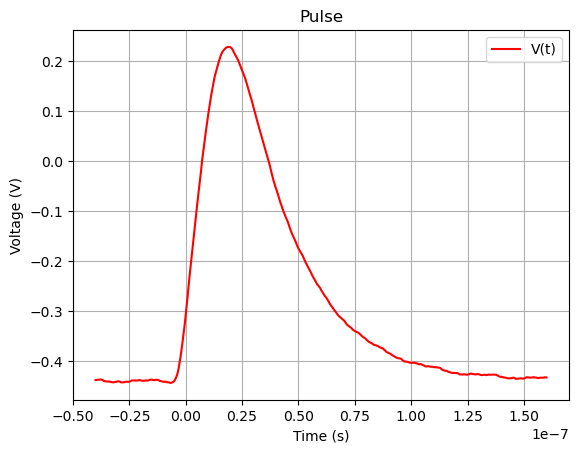

In [3]:
# Plotting the pulse V as a function of t

#plt.figure(figsize=(12,6))
plt.title("Pulse")
plt.plot(df["T"], df["V"], color = "red", label = "V(t)")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.grid()     
plt.legend()

## Transforming the pulse 

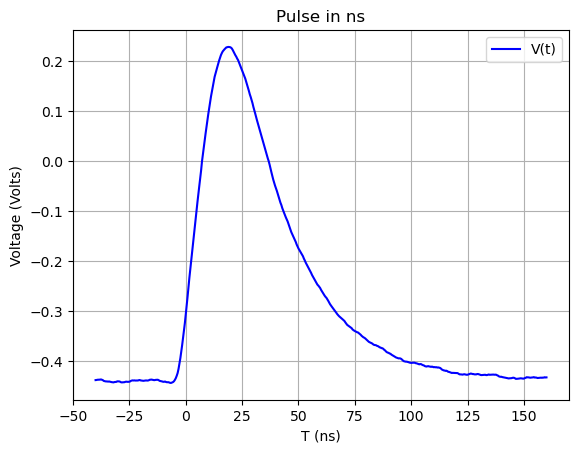

In [4]:
# Adding a column to `df` containing the time in ns, called `Tns`.
df["Tns"]  = df["T"]* (10**9)
df.head()

# Plotting the pulse in nanoseconds
plt.title("Pulse in ns")
plt.plot(df["Tns"], df["V"], color = "blue", label = "V(t)")
plt.xlabel("T (ns)")
plt.ylabel("Voltage (Volts)")
plt.grid()     
plt.legend()


### Pedestal of the pulse

The pedestal value is  -0.4393094


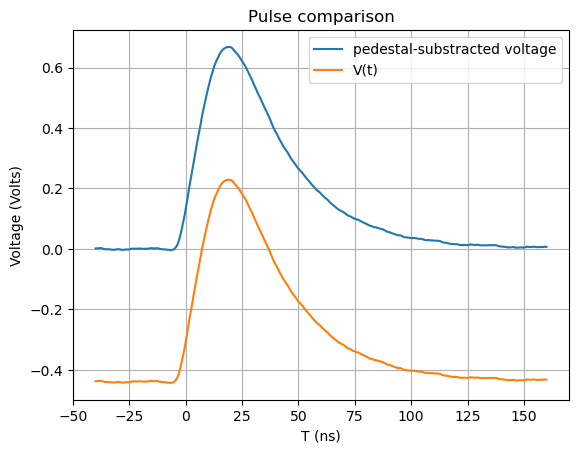

In [5]:
# Calculating the pedestal

before_pulse = df['Tns']<-10
pedestal = np.mean(df['V'][before_pulse])
print("The pedestal value is ", pedestal)


# Adding a `Vnorm` to `df` containing the pedestal-substracted voltage, and plotting

df["Vnorm"] = df["V"] - pedestal
plt.title("Pulse comparison")
plt.plot(df["Tns"], df["Vnorm"], label = "pedestal-substracted voltage")
plt.plot(df["Tns"], df["V"], label = "V(t)")
plt.xlabel("T (ns)")
plt.ylabel("Voltage (Volts)")
plt.grid()     
plt.legend()

The maximum value of Vnorm is 1.000 at time 18.80 ns
The minimum value of Vnorm is -0.006 at time -6.80 ns



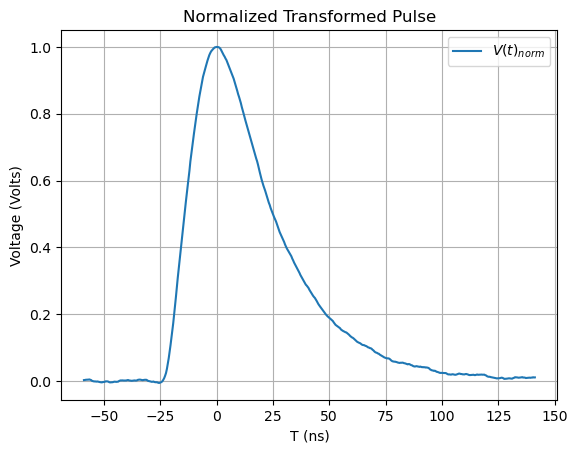

In [6]:
# Normalizing `Vnorm` to have a minumum of 0.0 and a maximum of 1.0

df["Vnorm"] = df["Vnorm"]/  np.max(df["Vnorm"])


# Finding the time with max amplitude (`Tmax`), minimum and maximum voltage value for 'Vnorm'

iTmax = np.argmax(df["Vnorm"])  # index of maximum Vnorm
T_max =  df["Tns"][iTmax]
Vnorm_max = np.max(df["Vnorm"])

iTmin = np.argmin(df["Vnorm"]) # index of minimum Vnorm
T_min =  df["Tns"][iTmin]
Vnorm_min = np.min(df["Vnorm"])

print(f"The maximum value of Vnorm is {Vnorm_max:.3f} at time {T_max:.2f} ns")
print(f"The minimum value of Vnorm is {Vnorm_min:.3f} at time {T_min:.2f} ns\n")


# centering Vnorm_mx at Tns = 0

df["Tns"] = df["Tns"] - T_max


# Plotting the transformed pulse satisfying `Tmax=0`, `Vmin=0` and `Vmax=1`
plt.title("Normalized Transformed Pulse")
plt.plot(df["Tns"],df["Vnorm"], label = "$V(t)_{norm}$")
plt.xlabel("T (ns)")
plt.ylabel("Voltage (Volts)")
plt.grid()     
plt.legend()


# Saving plot

plt.savefig("transformed_normalized_pulse.png", dpi=300, bbox_inches="tight")

## Pulse caracterization


The cumulative sum is defined as $\mathcal{V}(t) = \sum_{\tau\leq t} V(\tau)$


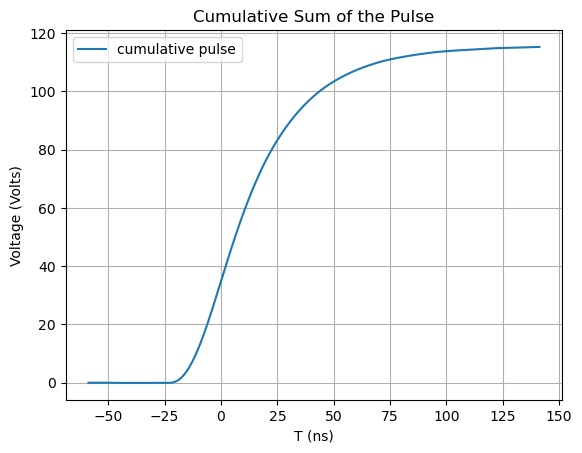

In [7]:
# Computing and plotting the cumulative sum of the pulse

cum_pulse = np.cumsum(df["Vnorm"])

plt.title("Cumulative Sum of the Pulse")
plt.plot(df['Tns'], cum_pulse, label = "cumulative pulse")
plt.xlabel("T (ns)")
plt.ylabel("Voltage (Volts)")
plt.grid()     
plt.legend()


# Saving plot

plt.savefig("cumulative_pulse.png", dpi=300, bbox_inches="tight")

### Full width of the pulse at its half maximum

This width is defined as $|t_1 - t_2|$ width $V(t_1)=V(t_2)=V_{\text{max}}/2$

In [8]:
# Get the Tleft defined as V(tLeft) = Vmax/2 (=0.5)
# by getting the index for which V (on the left) is 
# the closest to 0.5

pusle_left = df['Vnorm'][df['Tns']<0].values
iTleft = np.argmin(np.abs(pusle_left-0.5))
Tleft = df['Tns'][iTleft]



# Get the Tright defined as V(Tright) = Vmax/2 (=0.5)
# by getting the index for which V (on the right) is 
# the closest to 0.5

pusle_right = df['Vnorm'][df['Tns']>0].values
time_right  = df['Tns'][df['Tns']>0].values
iTright = np.argmin(np.abs(pusle_right-0.5))
Tright = time_right[iTright]
print("The full width is", Tright-Tleft)



The full width is 39.2


## Fit of the peak by a gaussian on the time window $[-10, 10]$ ns.

A gaussian function of amplitude $A$, average $\mu$ and width $\sigma$ can be expressed as

$$
\mathcal{G}(x) = A \, \exp\left( -\frac{(x - \mu)^2}{2\sigma^2} \right)
$$

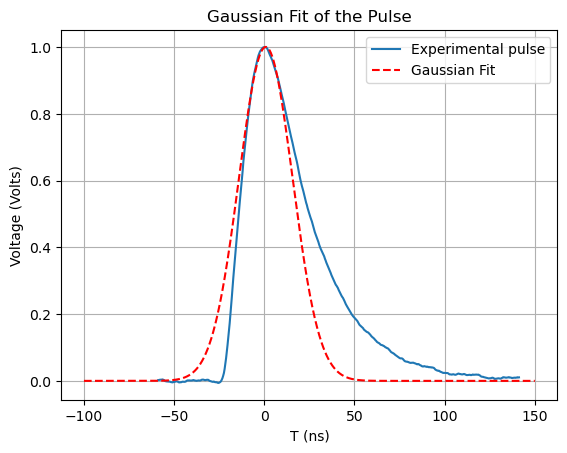

In [9]:
# Define the fit function

def gaussian(t, A, mu, sigma):
    return A*np.exp(-(t-mu)**2/(2*sigma**2))


# Define the fit range

fit_range = (-10<df['Tns']) & (df['Tns']<10)


# Perform the fiting

gauss_par, _ = curve_fit(gaussian, xdata=df['Tns'][fit_range], ydata=df['Vnorm'][fit_range])


# Getting the numpy array for the model prediction

time_fine = np.linspace(-100, 150, 1000)
fit_pulse = gaussian(time_fine, *gauss_par)


# Plot the results

plt.title("Gaussian Fit of the Pulse")
plt.plot(df['Tns'], df['Vnorm'], label='Experimental pulse')
plt.plot(time_fine, fit_pulse, label='Gaussian Fit', color = "red", linestyle = "--")
plt.xlabel("T (ns)")
plt.ylabel("Voltage (Volts)")
plt.grid()     
plt.legend()

# Saving plot

plt.savefig("gaussian_fit_pulse.png", dpi=300, bbox_inches="tight")